# Mitral Valve (MV) prediction on Echocardiography data using U-Nets

In [2]:
import pickle
import gzip
import numpy as np
import os
import pandas as pd

In [3]:
from utils import *

In [4]:
%load_ext autoreload
%autoreload 2

### Helper functions

### Load data, make predictions and save prediction in correct format

In [5]:
from keras.src.utils import set_random_seed
set_random_seed(1337)

In [6]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")

In [7]:
train_data[0]["label"].shape

(112, 112, 334)

In [8]:
amateur_data = [item for item in train_data if item["dataset"] == "amateur"]
expert_data = [item for item in train_data if item["dataset"] == "expert"]

amateur_names, amateur_videos, amateur_masks = preprocess_train_data(amateur_data)
expert_names, expert_videos, expert_masks = preprocess_train_data(expert_data)


100%|██████████| 19/19 [00:00<00:00, 74.68it/s]


In [9]:
names, videos, masks = preprocess_train_data(train_data)
test_names, test_videos = preprocess_test_data(test_data)

100%|██████████| 20/20 [00:00<00:00, 37.59it/s]


In [10]:
names, videos, masks, box = custom_preprocess_train_data(train_data)

100%|██████████| 65/65 [00:00<00:00, 155.83it/s]


# Inspect Train Data

In [11]:
train_data[0].keys()

dict_keys(['name', 'video', 'box', 'label', 'frames', 'dataset'])

In [12]:
train_data[0]["video"].shape

(112, 112, 334)

In [13]:
train_data[0]["box"].shape

(112, 112)

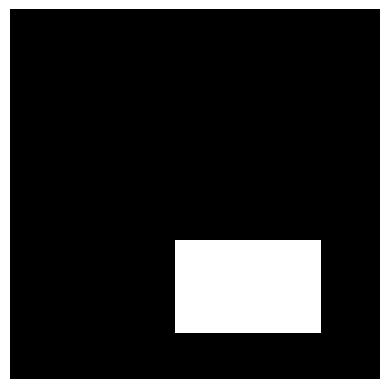

In [14]:
image = train_data[0]["box"]
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')  # Turn off axis labels
plt.show()

In [15]:
train_data[0]["label"].shape

(112, 112, 334)

In [16]:
train_data[0]["frames"]

[15, 59, 143]

In [17]:
train_data[0]["dataset"]

'amateur'

In [18]:
export_video(train_data[52]["video"], "video")

In [19]:
export_video(train_data[52]["label"], "label")

In [20]:
i = 0
export_video_to_labeler(i, train_data[i]["video"], train_data[i]["label"], train_data[i]["frames"])

# Inspect Test Data

In [21]:
test_videos[0].shape

(586, 821, 1)

In [22]:
export_video(test_data[0]["video"], "video")

In [23]:
for i in range(len(test_data)): 
    print(test_data[i]["video"].shape)

(586, 821, 103)
(587, 791, 52)
(583, 777, 69)
(582, 851, 61)
(732, 845, 53)
(583, 809, 84)
(582, 737, 78)
(587, 775, 125)
(730, 956, 76)
(587, 781, 104)
(583, 681, 68)
(587, 713, 90)
(587, 612, 78)
(587, 773, 73)
(707, 855, 39)
(731, 1007, 72)
(583, 780, 106)
(583, 670, 63)
(594, 745, 51)
(583, 779, 62)


# Resize Data

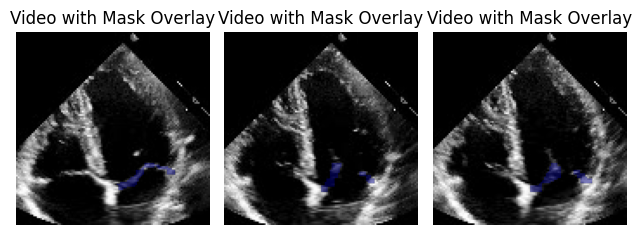

In [24]:

for i in range(3):  # Visualize 3 samples
    # Video and mask
    video = videos[i].squeeze()
    mask = masks[i].squeeze()

    # Overlay the mask on the video
    overlay = np.ma.masked_where(mask == 0, mask)  # Mask areas where the value is 0

    # Plot video frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(video, cmap='gray')  # Show the video
    plt.imshow(overlay, cmap='jet', alpha=0.5)  # Overlay the mask with transparency
    plt.title("Video with Mask Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
image_size = 128

resized_videos, resized_masks = resize_videos_with_padding_scale(videos, masks, (image_size,image_size), scale=True)
_, resized_box = resize_videos_with_padding_scale(videos, box, (image_size,image_size), scale=True)
resized_array_box = resized_array_masks = np.array(resized_box)

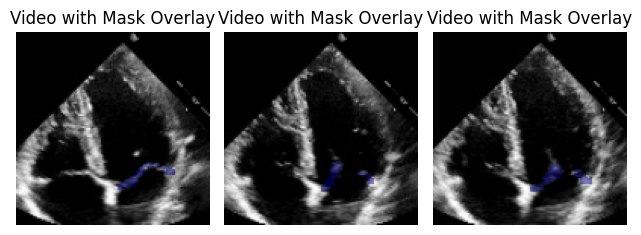

In [26]:

for i in range(3):  # Visualize 3 samples
    # Video and mask
    video = resized_videos[i].squeeze()
    mask = resized_masks[i].squeeze()

    # Overlay the mask on the video
    overlay = np.ma.masked_where(mask == 0, mask)  # Mask areas where the value is 0

    # Plot video frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(video, cmap='gray')  # Show the video
    plt.imshow(overlay, cmap='jet', alpha=0.5)  # Overlay the mask with transparency
    plt.title("Video with Mask Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [27]:
amateur_resized_videos, amateur_resized_masks = resize_videos_with_padding_scale(amateur_videos, amateur_masks, (image_size,image_size), scale=True)
expert_resized_videos, expert_resized_masks = resize_videos_with_padding_scale(expert_videos, expert_masks, (image_size,image_size), scale=True)

In [28]:
resized_array_videos = np.array(resized_videos)
resized_array_masks = np.array(resized_masks)

In [29]:
amateur_resized_array_videos = np.array(amateur_resized_videos)
amateur_resized_array_masks = np.array(amateur_resized_masks)

In [30]:
expert_resized_array_videos = np.array(expert_resized_videos)
expert_resized_array_masks = np.array(expert_resized_masks)

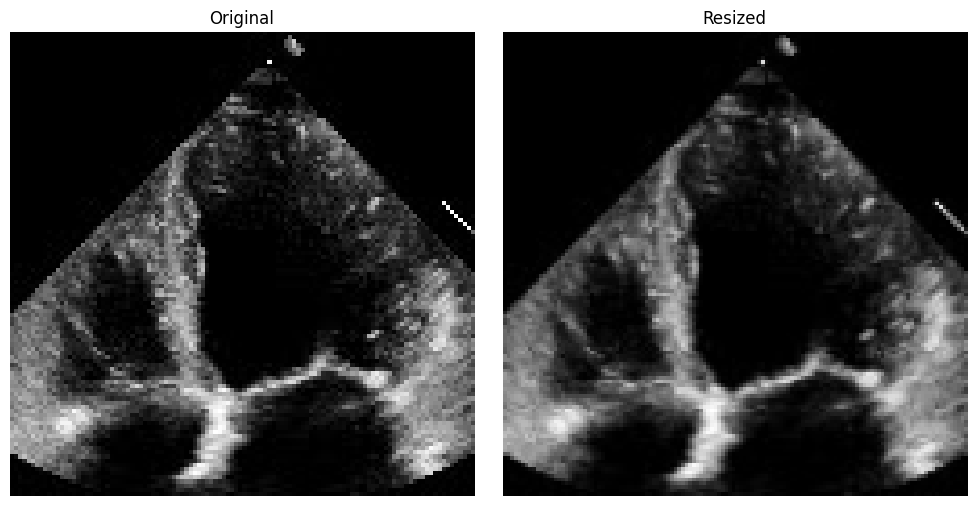

In [31]:
#Show resized
image_nr = 55
image_original = videos[image_nr]
image_rezized = resized_videos[image_nr]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_original, cmap='gray', interpolation='nearest')
axes[0].axis('off')  # Turn off axis labels
axes[0].set_title("Original")
axes[1].imshow(image_rezized, cmap='gray', interpolation='nearest')
axes[1].axis('off')  # Turn off axis labels
axes[1].set_title("Resized")
plt.tight_layout()
plt.show()

## Augmentation

### Datagenerator:

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for both videos and masks
video_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'   
)

mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest',
    preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype)
)

def data_generator(video_array, mask_array, batch_size):
    video_gen = video_datagen.flow(video_array, batch_size=batch_size, seed=1337)
    mask_gen = mask_datagen.flow(mask_array, batch_size=batch_size, seed=1337)
    
    for video_batch, mask_batch in zip(video_gen, mask_gen):
        yield video_batch, mask_batch

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## With these parameters it seemed to work best

common_params = {
    'rotation_range': 5,
    'width_shift_range': 0.05,
    'height_shift_range': 0.05,
    'shear_range': 0.01,
    'zoom_range': 0.05,
    'horizontal_flip': False,
    'vertical_flip': False,
    'fill_mode': 'constant'
}

video_datagen = ImageDataGenerator(**common_params)

mask_datagen = ImageDataGenerator(**common_params, preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) #binary guarantee

def data_generator(video_array, mask_array, batch_size):
    video_gen = video_datagen.flow(video_array, batch_size=batch_size, seed=1337)
    mask_gen = mask_datagen.flow(mask_array, batch_size=batch_size, seed=1337)
    
    for video_batch, mask_batch in zip(video_gen, mask_gen):
        yield video_batch, mask_batch

In [34]:
batch_size = 3

# Create the generators
train_generator = data_generator(resized_array_videos, resized_array_masks, batch_size)
amateur_train_generator = data_generator(amateur_resized_array_videos, amateur_resized_array_masks, batch_size)
expert_train_generator = data_generator(expert_resized_array_videos, expert_resized_array_masks, batch_size)

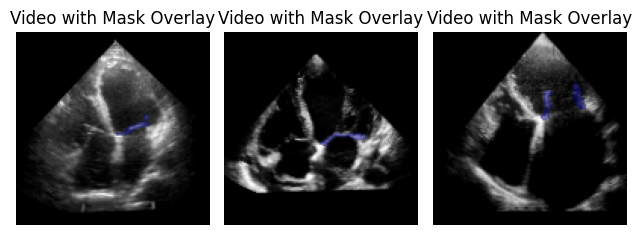

In [35]:
import matplotlib.pyplot as plt
import numpy as np

video_batch, mask_batch = next(expert_train_generator)

for i in range(3):  # Visualize 3 samples
    # Video and mask
    video = video_batch[i].squeeze()
    mask = mask_batch[i].squeeze()

    # Overlay the mask on the video
    overlay = np.ma.masked_where(mask == 0, mask)  # Mask areas where the value is 0

    # Plot video frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(video, cmap='gray')  # Show the video
    plt.imshow(overlay, cmap='jet', alpha=0.5)  # Overlay the mask with transparency
    plt.title("Video with Mask Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Model

### Losses:

In [36]:
import tensorflow as tf
from tensorflow.keras.backend import flatten, sum, epsilon

def iou_metric(y_true, y_pred):
    # Flatten the arrays to 1D for comparison
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    
    # Calculate the intersection and union
    intersection = sum(y_true_f * y_pred_f)
    union = sum(y_true_f) + sum(y_pred_f) - intersection
    
    # Return the IoU
    return intersection / (union + epsilon())  # Add epsilon to avoid division by zero

def iou_loss(y_true, y_pred):
    return 1 - iou_metric(y_true, y_pred)

In [37]:
def weighted_iou_metric(y_true, y_pred, alpha=2.0, beta=1.0, epsilon=1e-7):
    """
    Compute a weighted IoU metric to penalize false positives more heavily.
    
    Parameters:
    - y_true: Ground truth binary mask (array-like).
    - y_pred: Predicted binary mask (array-like).
    - alpha: Weight for false positives.
    - beta: Weight for false negatives.
    - epsilon: Small constant to avoid division by zero.
    
    Returns:
    - Weighted IoU score.
    """
    # Flatten the arrays to 1D for comparison
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    # Calculate components
    intersection = (y_true_f * y_pred_f).sum()
    false_positives = (y_pred_f * (1 - y_true_f)).sum()
    false_negatives = ((1 - y_pred_f) * y_true_f).sum()
    
    # Compute weighted IoU
    denominator = intersection + alpha * false_positives + beta * false_negatives + epsilon
    weighted_iou = intersection / denominator
    
    return weighted_iou

In [38]:
def composite_loss(y_true, y_pred):
    # y_true and y_pred are lists or tuples containing segmentation and ROI tensors
    y_true_seg, y_true_roi = y_true[0], y_true[1]  # Extract segmentation and ROI ground truths
    y_pred_seg, y_pred_roi = y_pred[0], y_pred[1]  # Extract segmentation and ROI predictions
    
    # Losses
    loss_seg = iou_metric(y_true_seg, y_pred_seg)
    loss_roi = iou_metric(y_true_roi, y_pred_roi)
    
    # Weighted combination
    alpha = 0.5
    return alpha * tf.reduce_mean(loss_seg) + (1 - alpha) * tf.reduce_mean(loss_roi)

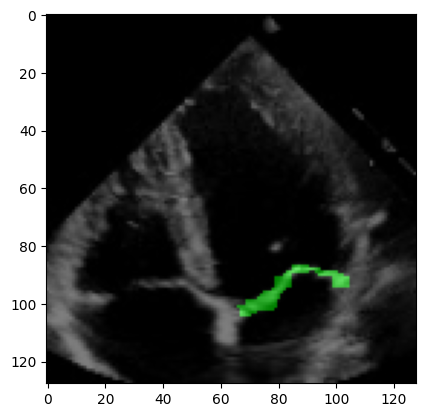

In [39]:
#Show masked image
plt.imshow(calculate_masked_image(resized_array_videos[0], resized_array_masks[0]))

## Get model

In [40]:
#use my custom model
from myUnet import *

experimental = False 
## Set true if you want to experiment in the experimental model with ROI prediction 
## -or want to build custom model with the Buildingblocks i wrote

if experimental == False:
    valve_model = build_myunet(input_shape=(image_size, image_size, 1), num_classes=1, dropout=0.3)
else:
    box_model = build_myunet(input_shape=(image_size, image_size, 1), num_classes=1, dropout=0.3)

In [41]:
## Initialize Optimizer here Adam with these Params turned out to do the job quite efficient

from tensorflow.keras.optimizers import Adam

initial_learning_rate = 1e-3  # Starting learning rate
decay_rate = 0.9           # Decay rate
decay_steps = 100          # Number of steps after which to apply decay

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # Set to True for step-wise decay
)

if experimental == False:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    valve_model.compile(optimizer=optimizer, loss=iou_loss, metrics=[iou_metric])
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    box_model.compile(optimizer=optimizer, loss=iou_loss, metrics=[iou_metric])

In [42]:
if experimental:
    history1 = box_model.fit(resized_array_videos, resized_array_box, epochs=10, batch_size=5, validation_split=0.1)

In [43]:
##Fit default U-net model on Data
history2 = valve_model.fit(resized_array_videos, resized_array_masks, epochs=20, steps_per_epoch=80, validation_split=0.1)

Epoch 1/20
59/80 ━━━━━━━━━━━━━━━━━━━━ 12s 575ms/step - iou_metric: 0.0279 - loss: 0.9721

/opt/anaconda3/envs/AML/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 436ms/step - iou_metric: 0.0311 - loss: 0.9690 - val_iou_metric: 0.0050 - val_loss: 0.9950
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 35s 431ms/step - iou_metric: 0.0924 - loss: 0.9078 - val_iou_metric: 0.0064 - val_loss: 0.9936
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - iou_metric: 0.2097 - loss: 0.7908 - val_iou_metric: 0.0000e+00 - val_loss: 1.0000
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 449ms/step - iou_metric: 0.4031 - loss: 0.5972 - val_iou_metric: 9.8557e-04 - val_loss: 0.9990
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 35s 440ms/step - iou_metric: 0.4817 - loss: 0.5186 - val_iou_metric: 0.0170 - val_loss: 0.9830
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - iou_metric: 0.4974 - loss: 0.5027 - val_iou_metric: 0.2776 - val_loss: 0.7224
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - iou_metric: 0.5362 - loss: 0.4638 - val_iou_metric: 0.3793 - val_loss: 0.6207
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 468ms/step - iou_metric: 0.547

### Fine tuning

In [44]:
## Activate fine tuning
for layer in valve_model.layers[:2]:
    layer.trainable = False
optimizer.learning_rate.assign(1e-5)

<tf.Tensor: shape=(), dtype=float32, numpy=9.999999747378752e-06>

In [45]:
## Fine tune Model on expert data
history2 = valve_model.fit(expert_train_generator, epochs=10, steps_per_epoch=80)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 632ms/step - iou_metric: 0.5490 - loss: 0.4510
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 617ms/step - iou_metric: 0.5656 - loss: 0.4344
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - iou_metric: 0.5813 - loss: 0.4187
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 611ms/step - iou_metric: 0.5779 - loss: 0.4221
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 616ms/step - iou_metric: 0.5790 - loss: 0.4210
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 634ms/step - iou_metric: 0.5846 - loss: 0.4154
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 614ms/step - iou_metric: 0.6010 - loss: 0.3990
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 609ms/step - iou_metric: 0.5937 - loss: 0.4063
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - iou_metric: 0.5930 - loss: 0.4070
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 621ms/step - iou_metric: 0.6070 - loss: 0.3930


In [49]:
##Save model
valve_model.save('default(20_10)_model.keras')

# Predict

## Train Set

In [46]:
## Predict with choosen model

if experimental == False: 
    predictions = valve_model.predict(resized_array_videos[:50, :, :, :])
else:
    predictions = box_model.predict(resized_array_videos[:50, :, :, :])
    #predicted_roi = box_model.predict(resized_array_videos[:50, :, :, :])
    predicted_segmentation = predictions 
    predictions=predicted_segmentation

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 994ms/step


In [47]:
predictions_threshold = (np.squeeze(predictions, axis=-1) > 0.9)

20


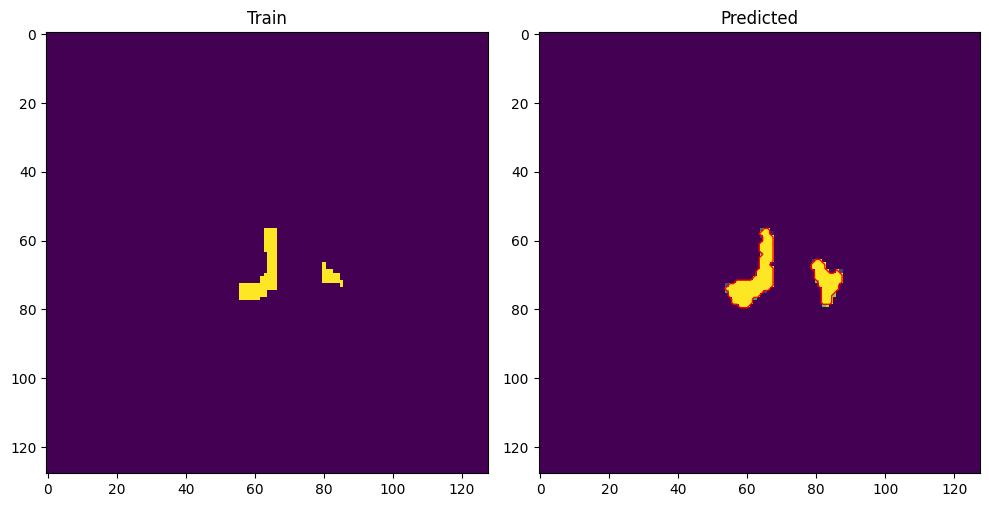

25


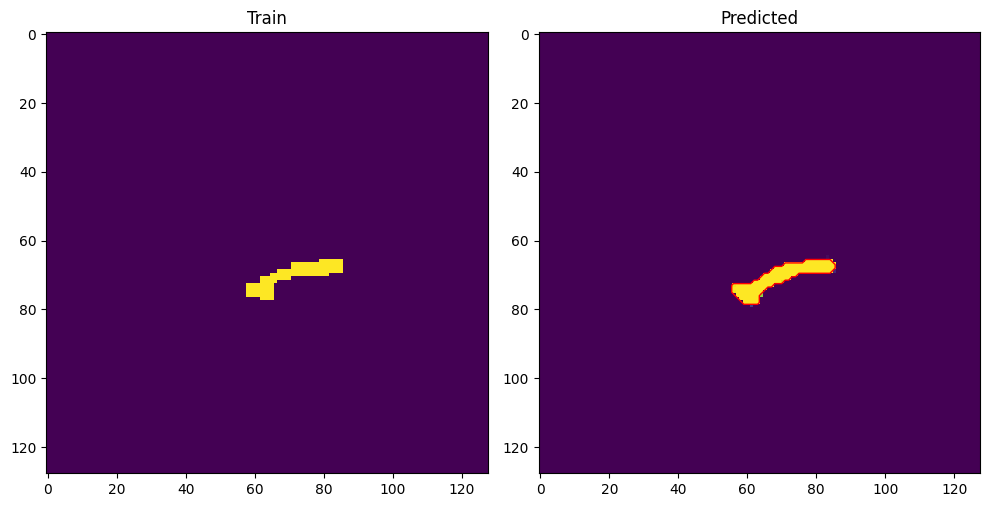

30


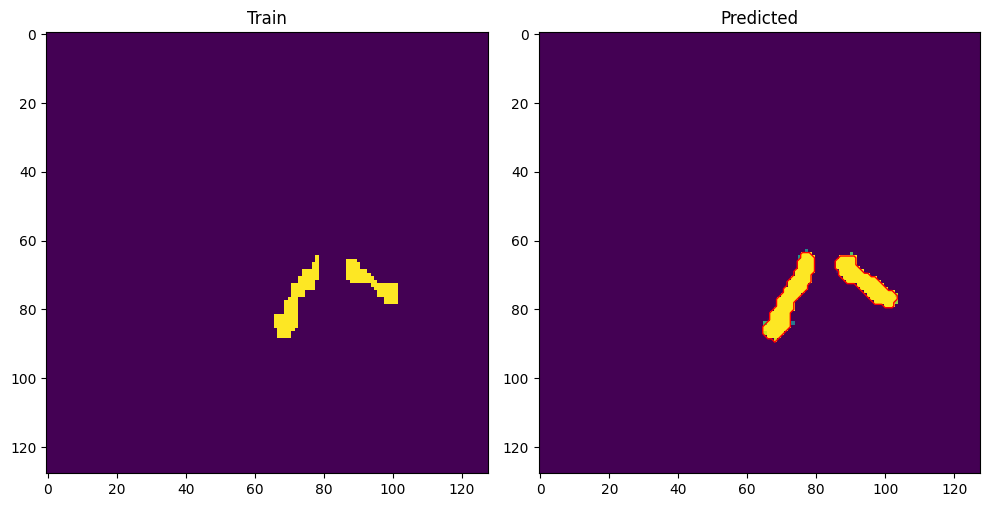

35


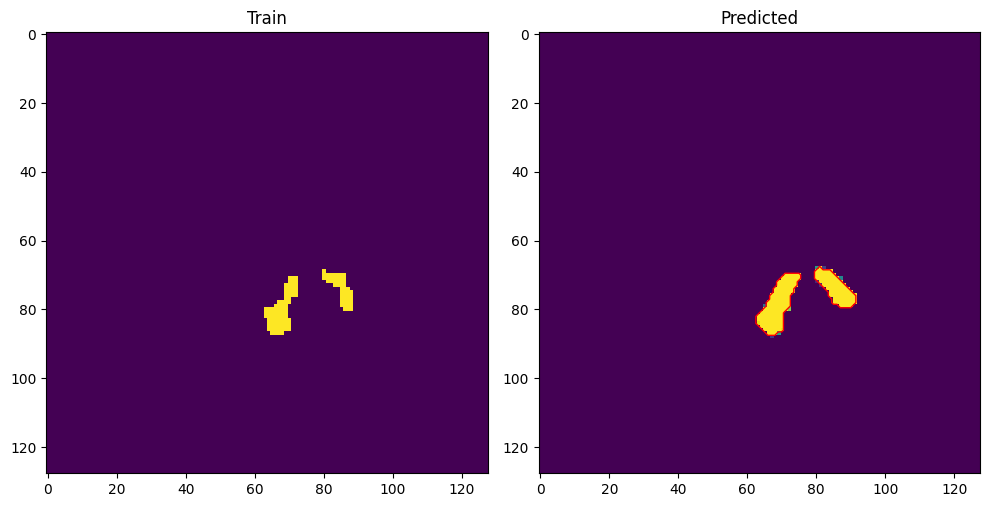

40


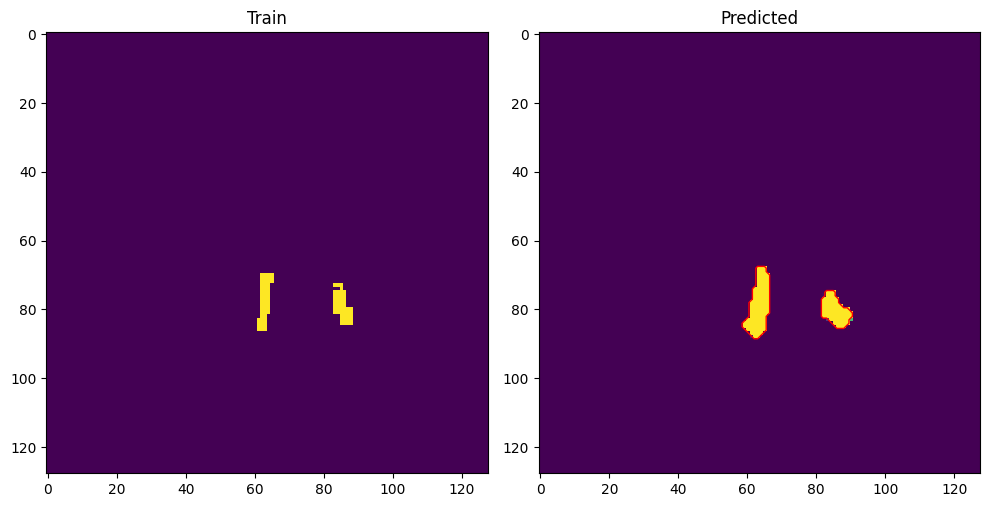

45


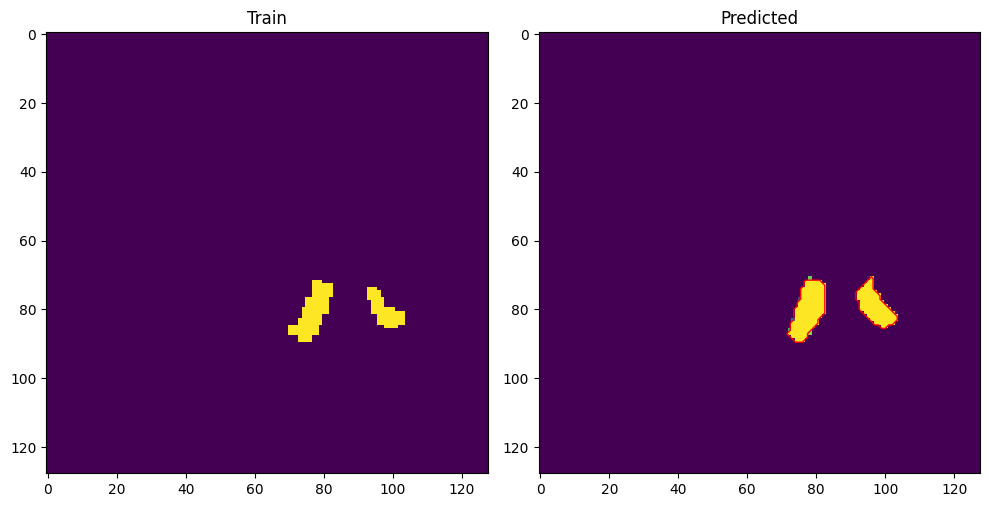

In [54]:
#Print comparison
def print_comparison(image_nr):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(resized_array_masks[image_nr, :, :, :])
    axes[0].set_title("Train")
    axes[1].imshow(predictions[image_nr])
    axes[1].contour(predictions_threshold[image_nr], colors='red', linewidths=1)  # Add borders for >90%
    axes[1].set_title("Predicted")
    plt.tight_layout()
    plt.show()

for i in range(len(predictions)):
    if i%5!=0 or i<20:
        continue
    print(i)
    print_comparison(i)

## Test Set

In [69]:
## Set model to use for predictions

if experimental == False:
    model = valve_model
else:
    model = box_model

In [70]:
def predict_video(id, model, test_data, test_videos, unscale=True, image_size=(image_size,image_size), threshold=0.9):
    # Select correct video from test_videos
    len_array = [test_data[i]["video"].shape[-1] for i in range(len(test_data))]
    start_index = int(np.sum(len_array[:id]))
    stop_index = int(start_index + len_array[id])
    test_video = test_videos[start_index:stop_index]
    # resize video
    resized_test_video, _ = resize_videos_with_padding_scale(test_video, None, image_size, scale=True)
    # predict mask for resized videos
    mask = valve_model.predict(np.array(resized_test_video)) #* box_model.predict(np.array(resized_test_video))
    # getting video into right shape
    for i in range(len(test_video)):
        resized_test_video[i] = np.squeeze(resized_test_video[i], axis=-1)
    videos, masks = np.stack(resized_test_video, axis=-1), (np.squeeze(mask, axis=-1) > threshold).transpose(1, 2, 0)

    predicted_video, predicted_mask =  undo_resize_videos_with_padding([videos], [test_data[id]["video"].shape[:2]], [masks], scale=True)
    return predicted_video[0], predicted_mask[0]


In [74]:
## Use these three blocks to peak into some specific predicitons and get a feel for the model before predicting everything

predicted_video, predicted_mask = predict_video(7, model, test_data, test_videos)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [75]:
predicted_mask.shape

(587, 775, 125)

In [76]:
## Look at individual predictions

export_video(predicted_video, "undoneVid")
export_video(predicted_mask, "undoneMask")

In [ ]:
## If you like the model run predicitions on every test sample

save_videos = True # This will export all predictions as .mp4 together with predicted mask as overlay

full_test_prediction = []
from playVideo import *
for i in range(len(test_data)):
    print(f"Processing Test Video {i}")
    predicted_video, predicted_mask = predict_video(i, model, test_data, test_videos)
    if save_videos:
        export_video(predicted_video, "undoneVid")
        export_video(predicted_mask, "undoneMask")
        save_video_with_mask("undoneVid", "undoneMask", output_filename=f"output_video_{i}.mp4", fps=30)
    full_test_prediction += [predicted_mask]

Processing Test Video 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Video saved to output_video_0.mp4
Processing Test Video 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 930ms/step
Video saved to output_video_1.mp4
Processing Test Video 2
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step
Video saved to output_video_2.mp4
Processing Test Video 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Video saved to output_video_3.mp4
Processing Test Video 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 957ms/step
Video saved to output_video_4.mp4
Processing Test Video 5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Video saved to output_video_5.mp4
Processing Test Video 6
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Video saved to output_video_6.mp4
Processing Test Video 7
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Video saved to output_video_7.mp4
Processing Test Video 8
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Video saved to output_video_8.mp4
Processing Test Video 9
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Video saved to output_video_9.mp4
Processing Test Video 10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3

# Create CSV

### Retrieve indices and length from flattened array

In [105]:
def get_sequences(arr):
    first_indices, last_indices, lengths = [], [], []
    n, i = len(arr), 0
    arr = [0] + list(arr) + [0]
    for index, value in enumerate(arr[:-1]):
        if arr[index+1]-arr[index] == 1:
            first_indices.append(index)
        if arr[index+1]-arr[index] == -1:
            last_indices.append(index)
    lengths = list(np.array(last_indices)-np.array(first_indices))
    return first_indices, lengths

In [106]:
id = []
values = []
for i, mask in enumerate(full_test_prediction):
    print(f"Processing Test Video {i}")
    first_indices, lengths = get_sequences(mask.flatten())
    for j, first_index in enumerate(first_indices):
        id.append(test_data[i]["name"] + "_" + str(j))
        values.append([first_indices[j], lengths[j]])


Processing Test Video 0
Processing Test Video 1
Processing Test Video 2
Processing Test Video 3
Processing Test Video 4
Processing Test Video 5
Processing Test Video 6
Processing Test Video 7
Processing Test Video 8
Processing Test Video 9
Processing Test Video 10
Processing Test Video 11
Processing Test Video 12
Processing Test Video 13
Processing Test Video 14
Processing Test Video 15
Processing Test Video 16
Processing Test Video 17
Processing Test Video 18
Processing Test Video 19


### Create .csv

In [107]:
import pandas as pd

df = pd.DataFrame({"id":id, "value":[list(map(int, minili)) for minili in values]})
#df = df[df["value"].apply(lambda x: x[1] > 1)]
df.to_csv(f"mysubmissionfile_test_new_UNET_experttuning_toomanyepochs.csv", index=False)

In [108]:
unique_prefixes = list({item.split('_')[0] for item in id})

In [109]:
# add label for this
set([test_data[i]["name"] for i in range(len(test_data))]) - set(unique_prefixes)

set()

In [110]:
[test_data[i]["name"] for i in range(len(test_data))]

['E9AHVWGBUF',
 'H7G0BX4HFV',
 '8FKMSXTPSJ',
 'JANFS05F33',
 'O7WUJ71C15',
 '1XHV0Q88M5',
 '401JD35E1A',
 'VODEK84RH4',
 'ONA22CCCFQ',
 '7UXIXUBK2G',
 'ESY800XYMN',
 '571G03ZYDA',
 'QZA3WA0E2X',
 'JQX264DTZ0',
 'TYM0IJW004',
 'CD4RIAOCHG',
 'D271IBSMUW',
 '0MVRNDWR1G',
 '1QSFD8ORNM',
 'UB7LFQKZT5']